In [2]:
%matplotlib inline 
import numpy as np
import xray
from xarray import ufuncs
import os
import math 
import gc 
import pandas as pd 
import matplotlib.pyplot as plt

IMPORT DATA FROM UI METDATA SITE

In [3]:
################################# INPUTS #############################
#lat = 48.03125
lat = 48.021
#lon = -121.28125
lon = -121.25
######################################################################

direc = '/raid/gergel/dfm_ui_metdata'
tmin_file1 = "tmmn_%s.nc" % "1981"
tmin_file2 = "tmmn_%s.nc" % "1982"
tmin_full1 = xray.open_dataset(os.path.join(direc,tmin_file1)) ## load tmin
tmin_full2 = xray.open_dataset(os.path.join(direc,tmin_file2)) ## load tmin
tmin_full = xray.concat([tmin_full1, tmin_full2], dim='day')

tmax_file1 = "tmmx_%s.nc" % "1981"
tmax_file2 = "tmmx_%s.nc" % "1982"
tmax_full1 = xray.open_dataset(os.path.join(direc,tmax_file1)) ## load tmax
tmax_full2 = xray.open_dataset(os.path.join(direc,tmax_file2)) ## load tmax
tmax_full = xray.concat([tmax_full1,tmax_full2], dim='day')

rhmin_file1 = "rmin_%s.nc" % "1981"
rhmin_file2 = "rmin_%s.nc" % "1982"
rhmin_full1 = xray.open_dataset(os.path.join(direc,rhmin_file1)) ## load rhmin
rhmin_full2 = xray.open_dataset(os.path.join(direc,rhmin_file2)) 
rhmin_full = xray.concat([rhmin_full1,rhmin_full2], dim='day')

rhmax_file1 = "rmax_%s.nc" % "1981"
rhmax_file2 = "rmax_%s.nc" % "1982"
rhmax_full1 = xray.open_dataset(os.path.join(direc,rhmax_file1)) ## load rhmin
rhmax_full2 = xray.open_dataset(os.path.join(direc,rhmax_file2)) 
rhmax_full = xray.concat([rhmax_full1,rhmax_full2], dim='day')

q_file1 = "sph_%s.nc" % "1981"
q_file2 = "sph_%s.nc" % "1982"
q_full1 = xray.open_dataset(os.path.join(direc,q_file1)) 
q_full2 = xray.open_dataset(os.path.join(direc,q_file2)) ## load specific humidity
q_full = xray.concat([q_full1,q_full2], dim='day')

pr_file1 = "pr_%s.nc" % "1981"
pr_file2 = "pr_%s.nc" % "1982"
pr_full1 = xray.open_dataset(os.path.join(direc,pr_file1)) 
pr_full2 = xray.open_dataset(os.path.join(direc,pr_file2)) ## load precip
pr_full = xray.concat([pr_full1,pr_full2], dim='day')

## select out gridcell 

lon_ind = np.argmin(np.abs(pr_full.lon - lon))
lat_ind = np.argmin(np.abs(pr_full.lat - lat))

## get julian days 
julians = pd.DatetimeIndex(np.asarray(pr_full.day)).dayofyear

# tmin = tmin_full[:,lat_ind,lon_ind]
tmin = tmin_full.isel_points(lon=[lon_ind],lat=[lat_ind])['air_temperature'].values[0,:]
tmax = tmax_full.isel_points(lon=[lon_ind],lat=[lat_ind])['air_temperature'].values[0,:]
q = q_full.isel_points(lon=[lon_ind],lat=[lat_ind])
pptamt = pr_full.isel_points(lon=[lon_ind],lat=[lat_ind])
rhmin = rhmin_full.isel_points(lon=[lon_ind],lat=[lat_ind])['relative_humidity'].values[0,:]
rhmax = rhmax_full.isel_points(lon=[lon_ind],lat=[lat_ind])['relative_humidity'].values[0,:]

del tmax_full, q_full,pr_full,rhmin_full,rhmax_full
gc.collect() 

310

100-hr and 1000-hr DFM FUNCTION 

In [4]:
def calc_fm100_fm1000(pptdur,maxrh,minrh,maxt,mint,lat,tmois,bv,julians,ymc100): 
    """this subroutine computes the average boundary conditions for the past 
    24 hour and 100-hr-tl fuel moisture. The boundary conditions are weighted averages 
    of the EQMCs calculated from the temp and RH values. Philab is used to calculate 
    daylength which is the basis of the weighting function.""" 

    emc1 = 0
    emc2 = 0
    emc = 0
    bndry1 = 0
    bndry = 0
    bvave = 0
    daylit = 0
    ambvp = 0
    fr100 = 0.3156

    '''# daylit = calcDaylight(j_date,lat) ########## need to write this function 
    #######################
    phi = lat * 0.01745 ## lat is in degrees 
    decl = 0.41008*np.sin(np.deg2rad((julians-82) * 0.01745))
    daylit = 24 * (1.0 - ((np.arccos(np.tan(np.deg2rad(phi)) * np.tan(np.deg2rad(decl))) / math.pi)))'''
    #######################
    
    ## John's calcDaylight function
    if julians > 365:
        julians = 365
    phi = lat * 0.01745 ## converts latitude to radians
    decl = .41008*np.sin((julians-82)*0.01745)
    daylit = 24.0*(1-np.arccos(np.tan(phi)*np.tan(decl))/3.14159)
    daylit = daylit.real
    
    #emc1 = np.ndarray(shape=(len(maxrh)),dtype='float')
    if minrh <= 10:
        emc1= 0.03229 + (0.281073 * minrh) - (0.000578 * minrh * maxt)
    elif minrh > 10 and minrh <= 50: 
        emc1 = 2.22749 + (0.160107 * minrh) - (0.014784 * maxt)
    else: 
        emc1 = 21.0606 + (0.005565 * (minrh**2)) - (0.00035 * minrh * maxt) - (0.483199 * minrh)

    #emc2 = np.ndarray(shape=(len(maxrh)),dtype='float')
    if maxrh <= 10:
        emc2 = 0.03229 + (0.281073 * maxrh) - (0.000578 * maxrh* mint)
    elif maxrh > 10 and maxrh <= 50: 
        emc2 = 2.22749 + (0.160107 * maxrh) - (0.014784 * mint)
    else: 
        emc2 = 21.0606 + (0.005565 * (maxrh**2)) - (0.00035 * maxrh * mint) - (0.483199 * maxrh)

    '''phours = np.ndarray(shape=(len(maxrh)),dtype='float')
    for day in np.arange(len(minrh)):
        if pptamt[day] > 0 and pptdur >= 0 and climcl < 3:
            phours[day] = ((pptamt[day]/0.25) + 0.4999) + 0.5 
        elif pptamt[day] > 0 and pptdur >= 0 and climcl >= 3:
            phours[day] = ((pptamt[day]/0.05) + 0.4999) + 0.5 
        elif pptamt[day]
    '''
    
    '''if pptamt > 0:
        pptdur = ((pptamt/0.05) + 0.4999) + 0.5
    else:
        pptdur = 0'''
    
    ## qc maxrh 
    # for day in np.arange(len(emc1)):
    if np.isnan(maxrh):
        emc1 = np.nan
        emc2 = np.nan 

    emc = (daylit * emc1 + (24.0 - daylit) * emc2) / 24.0 

    ## qc precip duration 
    # for day in np.arange(len(pptdur)):
    
    # pptdur = pptdur*1.25
    
    if pptdur < 0:
        pptdur = 0
    elif pptdur > 8:
        pptdur = 8
        
    bndry1 = ((24 - pptdur) * emc + (0.5 * pptdur + 41) * pptdur) / 24.0 
    fm100 = ((bndry1 - ymc100) * fr100) + ymc100 
    ## calculate 1000-hr fuel moisture daily using average of boundary conditions for
    ## past seven days. starting value set by climate type. 

    fr1 = 0.3068

    bvave = 0

    ## accumulate a 6-day total
    for i in np.arange(0,6):
        bv[:,i] = bv[:,i+1]
        bvave = bvave + bv[:,i]

    bndry = ((24 - pptdur) * emc + (2.7 * pptdur + 76) * pptdur) / 24.0 
    bv[:,6] = bndry

    ## add today's boundary from subfm100, divide by 7 days 
    bvave = (bvave + bndry) / 7.0 

    ## calculate today's 1000 hr fuel moisture 
    # fm1000 = tmois[:,1] + (bvave - tmois[:,1])*fr1 
    fm1000 = tmois[:,0] + (bvave - tmois[:,0])*fr1

    ## move each days 1000 hr down one, drop the oldest 
    for i in np.arange(0,6):
        tmois[:,i] = tmois[:,i+1] 
    tmois[:,6] = fm1000 

    return(tmois,fm1000,fm100,bv)

IMPORT BETA VALUES AND APPLY EMPIRICAL TRANSFORM 

In [5]:
direc = '/raid/gergel'
pdur_file = 'pduration.nc'
pdur_full = xray.open_dataset(os.path.join(direc,pdur_file)) ## pdur beta parameter for John's transform from Matt Jolly
## select out gridcell for pdur b parameter
lon_ind_1 = np.argmin(np.abs(pdur_full.lon - lon))
lat_ind_1 = np.argmin(np.abs(pdur_full.lat - lat))
beta = pdur_full.isel_points(lon=[lon_ind_1],lat=[lat_ind_1])
#beta = 5.6

pptamt_in = pptamt * 0.0393701 ## convert from mm to inches 
pptdur_calc_df = pptamt_in['precipitation_amount'].to_series().map(lambda x: int(24 * (1 - (np.exp(-beta['pdur']*x)))) 
                                                            if (x > 0) else 0) 
pptdur = xray.DataArray.from_series(pptdur_calc_df).to_dataset()['precipitation_amount'].values[0,:]

ITERATE AND CALCULATE 100-HR AND 1000-HR DFM

In [6]:
x = 1
import math 

tmois=np.zeros(shape=(x,7))
bv=np.zeros(shape=(x,7))
ymc=np.zeros(shape=(x,1))
ndays = len(rhmax)

fm1000 = np.ndarray(shape=(x,ndays),dtype='float')
fm100 = np.ndarray(shape=(x,ndays),dtype='float')


for day in np.arange(ndays):
    # pptdur_day = int(24.0 * (1 - math.exp(-1*beta['pdur'].values[0]*pptamt_day))) ## to cross check pptdur calc above
    tmois,fm1000[0,day],fm100[0,day],bv = calc_fm100_fm1000(pptdur[day],rhmax[day],rhmin[day],tmax[day],tmin[day],
                                                            48,tmois,bv,julians[day],ymc)
    ymc=fm100[0,day]


IMPORT UI METDATA SITE DFM

In [7]:
direc = '/raid/gergel/dfm_ui_metdata' 
file = "fm100_1981.nc" 
ds = xray.open_dataset(os.path.join(direc,file)) 

file2 = "fm100_1982.nc" 
ds2 = xray.open_dataset(os.path.join(direc,file2))
                        
## concatenate netcdf files 
ds_full = xray.concat([ds, ds2], dim='day')

In [8]:
import datetime as dt
import matplotlib.pyplot as plt
tp_start = dt.datetime(1981,10,1)
tp_end = dt.datetime(1982,10,1)


ui_start = dt.datetime(1980,12,31)
ui_end = dt.datetime(1982,12,31)
arr_ui = [ui_start + dt.timedelta(days=i) for i in range(0, (ui_end-ui_start).days)]
dates_ui = np.asarray(arr_ui)

IMPORT DATA FROM JOHN 

In [9]:
direc = '/raid/gergel'
filename = 'diana_fm100_fm1000.csv'
df = pd.read_csv(os.path.join(direc,filename))
dss = xray.Dataset.from_dataframe(df)
# ds_sel = ds.isel_points(lon=[lon_ind],lat=[lat_ind])
# ds['year'].values = ds['year'].values.astype(str)
# ds_sel = ds.loc[dict(year=slice(1981, 1982))]
dss['year'][366+366+275]
start = (2*366)+275
end = (3*366)+275
ds_sel = dss['fm100'][start:end]
ds_time = dss['day'][start:end]
bool_arr = np.ndarray(shape=(len(ds_sel)),dtype='bool')
for i in np.arange(len(ds_sel)):
    if ds_time[i] == 60:
        bool_arr[i] = False
    else:
        bool_arr[i] = True
dfm_john = ds_sel.squeeze()[bool_arr]
dfm1000_john = dss['f1000'][start:end].squeeze()[bool_arr]

PLOT AND COMPARE RESULTS

saving figure to '/raid9/gergel/agg_snowpack/feb1_2'


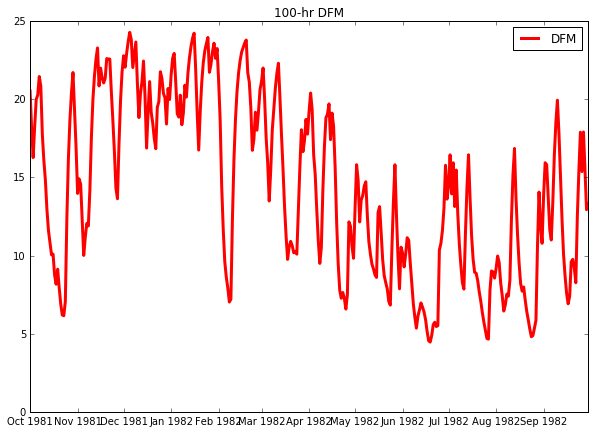

In [14]:
%matplotlib inline 
import matplotlib.pyplot as plt

tp_start = dt.datetime(1981,10,1)
tp_end = dt.datetime(1982,10,1)
date_range = [tp_start + dt.timedelta(days=i) for i in range(0, (tp_end-tp_start).days)]

lw = 3.0
lt = 10
rt = 7

fig = plt.figure(figsize=(lt,rt))

lon_ind = np.argmin(np.abs(ds.lon - lon))
lat_ind = np.argmin(np.abs(ds.lat - lat))

dfm = ds_full.isel_points(lon=[lon_ind_1],lat=[lat_ind_1])
dfm_sel = dfm.sel(day=slice('1981-10-01', '1982-9-30'))
# dfm_sel['dead_fuel_moistue_100hr'].plot(label='UI MetData DFM',color='b',linewidth=lw)

# plt.plot(date_range,dfm_john,label='DFM from John',color='g',linewidth=lw)

plt.plot(date_range,fm100[0,:][(dates_ui >= tp_start) * (dates_ui < tp_end)],linewidth=lw,color='r',
         label='DFM')

plt.title('100-hr DFM')
plt.legend()

## save plot
direc = '/raid9/gergel/agg_snowpack/'
plotname = 'feb1_2' 
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath)

In [11]:
print(np.corrcoef(dfm_john,fm100[0,:][(dates_ui >= tp_start) * (dates_ui < tp_end)]))

[[ 1.          0.99377126]
 [ 0.99377126  1.        ]]


[[ 1.         0.9986312]
 [ 0.9986312  1.       ]]
saving figure to '/raid9/gergel/agg_snowpack/feb1_3'


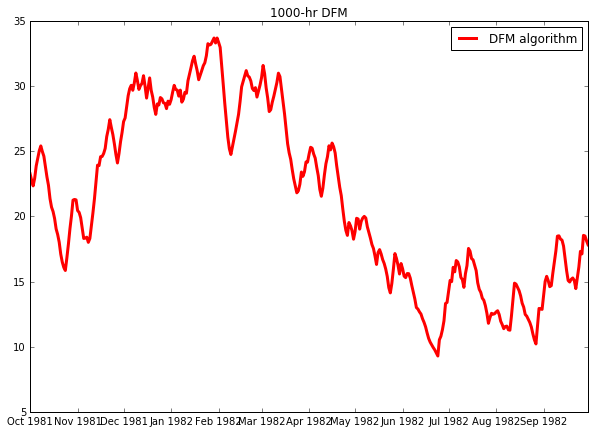

In [15]:
fig = plt.figure(figsize=(lt,rt))

# plt.plot(date_range,dfm1000_john,label='DFM from John',color='g',linewidth=lw)

plt.plot(date_range,fm1000[0,:][(dates_ui >= tp_start) * (dates_ui < tp_end)],linewidth=lw,color='r',
         label='DFM algorithm')
plt.title('1000-hr DFM')
plt.legend()

print(np.corrcoef(dfm1000_john,fm1000[0,:][(dates_ui >= tp_start) * (dates_ui < tp_end)]))

## save plot
direc = '/raid9/gergel/agg_snowpack/'
plotname = 'feb1_3' 
savepath = os.path.join(direc, plotname)
print ("saving figure to '%s'" % savepath)
plt.savefig(savepath)

WRITE TO CSV FILE

In [13]:
d = {'rhmax': rhmax,'rhmin': rhmin,'tmax':tmax, 'tmin':tmin, 'precip': pptamt_in['precipitation_amount'].values[0,:],
     'julian_day':julians,'fm100':fm100[0,:],'fm1000':fm1000[0,:]}
df_for_csv = pd.DataFrame(data=d)
df_for_csv
df_for_csv.to_csv('/raid/gergel/csv_for_john.csv')